In [1]:
import numpy as np
import numpy.random as rn
import matplotlib.pyplot as plt

class Gridworld(object):
    """
    Gridworld MDP.
    """

    def __init__(self, grid_size, wind, discount):
        """
        grid_size: Grid size. int.
        wind: Chance of moving randomly. float.
        discount: MDP discount. float.
        -> Gridworld
        """

        self.actions = ((1, 0), (0, 1), (-1, 0), (0, -1))
        self.n_actions = len(self.actions)
        self.n_states = grid_size**2
        self.grid_size = grid_size
        self.wind = wind
        self.discount = discount

        # Preconstruct the transition probability array.
        self.transition_probability = np.array(
            [[[self._transition_probability(i, j, k)
               for k in range(self.n_states)]
              for j in range(self.n_actions)]
             for i in range(self.n_states)])

    def __str__(self):
        return "Gridworld({}, {}, {})".format(self.grid_size, self.wind,
                                              self.discount)

    def feature_vector(self, i, feature_map="ident"):
        """
        Get the feature vector associated with a state integer.
        i: State int.
        feature_map: Which feature map to use (default ident). String in {ident,
            coord, proxi}.
        -> Feature vector.
        """

        if feature_map == "coord":
            f = np.zeros(self.grid_size)
            x, y = i % self.grid_size, i // self.grid_size
            f[x] += 1
            f[y] += 1
            return f
        if feature_map == "proxi":
            f = np.zeros(self.n_states)
            x, y = i % self.grid_size, i // self.grid_size
            for b in range(self.grid_size):
                for a in range(self.grid_size):
                    dist = abs(x - a) + abs(y - b)
                    f[self.point_to_int((a, b))] = dist
            return f
        # Assume identity map.
        f = np.zeros(self.n_states)
        f[i] = 1
        return f

    def feature_matrix(self, feature_map="ident"):
        """
        Get the feature matrix for this gridworld.
        feature_map: Which feature map to use (default ident). String in {ident,
            coord, proxi}.
        -> NumPy array with shape (n_states, d_states).
        """

        features = []
        for n in range(self.n_states):
            f = self.feature_vector(n, feature_map)
            features.append(f)
        return np.array(features)

    def int_to_point(self, i):
        """
        Convert a state int into the corresponding coordinate.
        i: State int.
        -> (x, y) int tuple.
        """

        return (i % self.grid_size, i // self.grid_size)

    def point_to_int(self, p):
        """
        Convert a coordinate into the corresponding state int.
        p: (x, y) tuple.
        -> State int.
        """

        return p[0] + p[1]*self.grid_size

    def neighbouring(self, i, k):
        """
        Get whether two points neighbour each other. Also returns true if they
        are the same point.
        i: (x, y) int tuple.
        k: (x, y) int tuple.
        -> bool.
        """

        return abs(i[0] - k[0]) + abs(i[1] - k[1]) <= 1

    def _transition_probability(self, i, j, k):
        """
        Get the probability of transitioning from state i to state k given
        action j.
        i: State int.
        j: Action int.
        k: State int.
        -> p(s_k | s_i, a_j)
        """

        xi, yi = self.int_to_point(i)
        xj, yj = self.actions[j]
        xk, yk = self.int_to_point(k)

        if not self.neighbouring((xi, yi), (xk, yk)):
            return 0.0

        # Is k the intended state to move to?
        if (xi + xj, yi + yj) == (xk, yk):
            return 1 - self.wind + self.wind/self.n_actions

        # If these are not the same point, then we can move there by wind.
        if (xi, yi) != (xk, yk):
            return self.wind/self.n_actions

        # If these are the same point, we can only move here by either moving
        # off the grid or being blown off the grid. Are we on a corner or not?
        if (xi, yi) in {(0, 0), (self.grid_size-1, self.grid_size-1),
                        (0, self.grid_size-1), (self.grid_size-1, 0)}:
            # Corner.
            # Can move off the edge in two directions.
            # Did we intend to move off the grid?
            if not (0 <= xi + xj < self.grid_size and
                    0 <= yi + yj < self.grid_size):
                # We intended to move off the grid, so we have the regular
                # success chance of staying here plus an extra chance of blowing
                # onto the *other* off-grid square.
                return 1 - self.wind + 2*self.wind/self.n_actions
            else:
                # We can blow off the grid in either direction only by wind.
                return 2*self.wind/self.n_actions
        else:
            # Not a corner. Is it an edge?
            if (xi not in {0, self.grid_size-1} and
                yi not in {0, self.grid_size-1}):
                # Not an edge.
                return 0.0

            # Edge.
            # Can only move off the edge in one direction.
            # Did we intend to move off the grid?
            if not (0 <= xi + xj < self.grid_size and
                    0 <= yi + yj < self.grid_size):
                # We intended to move off the grid, so we have the regular
                # success chance of staying here.
                return 1 - self.wind + self.wind/self.n_actions
            else:
                # We can blow off the grid only by wind.
                return self.wind/self.n_actions

    def reward(self, state_int):
        """
        Reward for being in state state_int.
        state_int: State integer. int.
        -> Reward.
        """

        if state_int == self.n_states - 1:
            return 1
        return 0

    def average_reward(self, n_trajectories, trajectory_length, policy):
        """
        Calculate the average total reward obtained by following a given policy
        over n_paths paths.
        policy: Map from state integers to action integers.
        n_trajectories: Number of trajectories. int.
        trajectory_length: Length of an episode. int.
        -> Average reward, standard deviation.
        """

        trajectories = self.generate_trajectories(n_trajectories,
                                             trajectory_length, policy)
        rewards = [[r for _, _, r in trajectory] for trajectory in trajectories]
        rewards = np.array(rewards)

        # Add up all the rewards to find the total reward.
        total_reward = rewards.sum(axis=1)

        # Return the average reward and standard deviation.
        return total_reward.mean(), total_reward.std()

    def optimal_policy(self, state_int):
        """
        The optimal policy for this gridworld.
        state_int: What state we are in. int.
        -> Action int.
        """

        sx, sy = self.int_to_point(state_int)

        if sx < self.grid_size and sy < self.grid_size:
            return rn.randint(0, 2)
        if sx < self.grid_size-1:
            return 0
        if sy < self.grid_size-1:
            return 1
        raise ValueError("Unexpected state.")

    def optimal_policy_deterministic(self, state_int):
        """
        Deterministic version of the optimal policy for this gridworld.
        state_int: What state we are in. int.
        -> Action int.
        """

        sx, sy = self.int_to_point(state_int)
        if sx < sy:
            return 0
        return 1

    def generate_trajectories(self, n_trajectories, trajectory_length, policy,
                                    random_start=False):
        """
        Generate n_trajectories trajectories with length trajectory_length,
        following the given policy.
        n_trajectories: Number of trajectories. int.
        trajectory_length: Length of an episode. int.
        policy: Map from state integers to action integers.
        random_start: Whether to start randomly (default False). bool.
        -> [[(state int, action int, reward float)]]
        """

        trajectories = []
        for _ in range(n_trajectories):
            if random_start:
                sx, sy = rn.randint(self.grid_size), rn.randint(self.grid_size)
            else:
                sx, sy = 0, 0

            trajectory = []
            for _ in range(trajectory_length):
                if rn.random() < self.wind:
                    action = self.actions[rn.randint(0, 4)]
                else:
                    # Follow the given policy.
                    action = self.actions[policy(self.point_to_int((sx, sy)))]

                if (0 <= sx + action[0] < self.grid_size and
                        0 <= sy + action[1] < self.grid_size):
                    next_sx = sx + action[0]
                    next_sy = sy + action[1]
                else:
                    next_sx = sx
                    next_sy = sy

                state_int = self.point_to_int((sx, sy))
                action_int = self.actions.index(action)
                next_state_int = self.point_to_int((next_sx, next_sy))
                reward = self.reward(next_state_int)
                trajectory.append((state_int, action_int, reward))

                sx = next_sx
                sy = next_sy

            trajectories.append(trajectory)

        return np.array(trajectories)

In [2]:
import random

import numpy as np
from cvxopt import matrix, solvers

def irl(n_states, n_actions, transition_probability, policy, discount, Rmax,
        l1):
    """
    Find a reward function with inverse RL as described in Ng & Russell, 2000.
    n_states: Number of states. int.
    n_actions: Number of actions. int.
    transition_probability: NumPy array mapping (state_i, action, state_k) to
        the probability of transitioning from state_i to state_k under action.
        Shape (N, A, N).
    policy: Vector mapping state ints to action ints. Shape (N,).
    discount: Discount factor. float.
    Rmax: Maximum reward. float.
    l1: l1 regularisation. float.
    -> Reward vector
    """

    A = set(range(n_actions))  # Set of actions to help manage reordering
                               # actions.
    # The transition policy convention is different here to the rest of the code
    # for legacy reasons; here, we reorder axes to fix this. We expect the
    # new probabilities to be of the shape (A, N, N).
    transition_probability = np.transpose(transition_probability, (1, 0, 2))

    def T(a, s):
        """
        Shorthand for a dot product used a lot in the LP formulation.
        """

        return np.dot(transition_probability[policy[s], s] -
                      transition_probability[a, s],
                      np.linalg.inv(np.eye(n_states) -
                        discount*transition_probability[policy[s]]))

    # This entire function just computes the block matrices used for the LP
    # formulation of IRL.

    # Minimise c . x.
    c = -np.hstack([np.zeros(n_states), np.ones(n_states),
                    -l1*np.ones(n_states)])
    zero_stack1 = np.zeros((n_states*(n_actions-1), n_states))
    T_stack = np.vstack([
        -T(a, s)
        for s in range(n_states)
        for a in A - {policy[s]}
    ])
    I_stack1 = np.vstack([
        np.eye(1, n_states, s)
        for s in range(n_states)
        for a in A - {policy[s]}
    ])
    I_stack2 = np.eye(n_states)
    zero_stack2 = np.zeros((n_states, n_states))

    D_left = np.vstack([T_stack, T_stack, -I_stack2, I_stack2])
    D_middle = np.vstack([I_stack1, zero_stack1, zero_stack2, zero_stack2])
    D_right = np.vstack([zero_stack1, zero_stack1, -I_stack2, -I_stack2])

    D = np.hstack([D_left, D_middle, D_right])
    b = np.zeros((n_states*(n_actions-1)*2 + 2*n_states, 1))
    bounds = np.array([(None, None)]*2*n_states + [(-Rmax, Rmax)]*n_states)

    # We still need to bound R. To do this, we just add
    # -I R <= Rmax 1
    # I R <= Rmax 1
    # So to D we need to add -I and I, and to b we need to add Rmax 1 and Rmax 1
    D_bounds = np.hstack([
        np.vstack([
            -np.eye(n_states),
            np.eye(n_states)]),
        np.vstack([
            np.zeros((n_states, n_states)),
            np.zeros((n_states, n_states))]),
        np.vstack([
            np.zeros((n_states, n_states)),
            np.zeros((n_states, n_states))])])
    b_bounds = np.vstack([Rmax*np.ones((n_states, 1))]*2)
    D = np.vstack((D, D_bounds))
    b = np.vstack((b, b_bounds))
    A_ub = matrix(D)
    b = matrix(b)
    c = matrix(c)
    results = solvers.lp(c, A_ub, b)
    r = np.asarray(results["x"][:n_states], dtype=np.double)

    return r.reshape((n_states,))


In [3]:
def main(grid_size, l1):
    """
    Run linear programming inverse reinforcement learning on the gridworld MDP.
    Plots the reward function.
    grid_size: Grid size. int.
    discount: MDP discount factor. float.
    """

    wind = 0.3
    trajectory_length = 3*grid_size

    gw = Gridworld(grid_size, wind, 0.2)

    ground_r = np.array([gw.reward(s) for s in range(gw.n_states)])
    policy = [gw.optimal_policy_deterministic(s) for s in range(gw.n_states)]
    r = irl(gw.n_states, gw.n_actions, gw.transition_probability,
            policy, gw.discount, 1, l1)
    
    plt.figure(figsize=(16,5))
    plt.subplot(1, 2, 1)
    plt.pcolor(ground_r.reshape((grid_size, grid_size)))
    plt.colorbar()
    plt.title("Groundtruth reward")
    plt.subplot(1, 2, 2)
    plt.pcolor(r.reshape((grid_size, grid_size)))
    plt.colorbar()
    plt.title("Recovered reward")
    plt.show()
    return r

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -6.5658e+01  4e+02  2e+00  7e+00  1e+00
 1: -9.0720e-01 -1.3791e+01  5e+01  5e-01  2e+00  1e+00
 2: -1.8614e+00 -6.0577e+00  1e+01  2e-01  5e-01  3e-01
 3: -2.5275e+00 -4.0287e+00  5e+00  5e-02  2e-01  1e-01
 4: -2.8839e+00 -3.3451e+00  1e+00  2e-02  5e-02  3e-02
 5: -3.0320e+00 -3.2038e+00  5e-01  6e-03  2e-02  1e-02
 6: -3.0467e+00 -3.1523e+00  3e-01  4e-03  1e-02  3e-03
 7: -3.0921e+00 -3.1187e+00  8e-02  9e-04  3e-03  8e-04
 8: -3.1033e+00 -3.1065e+00  1e-02  1e-04  4e-04  4e-05
 9: -3.1050e+00 -3.1050e+00  2e-04  2e-06  8e-06  8e-07
10: -3.1050e+00 -3.1050e+00  2e-06  2e-08  8e-08  8e-09
Optimal solution found.


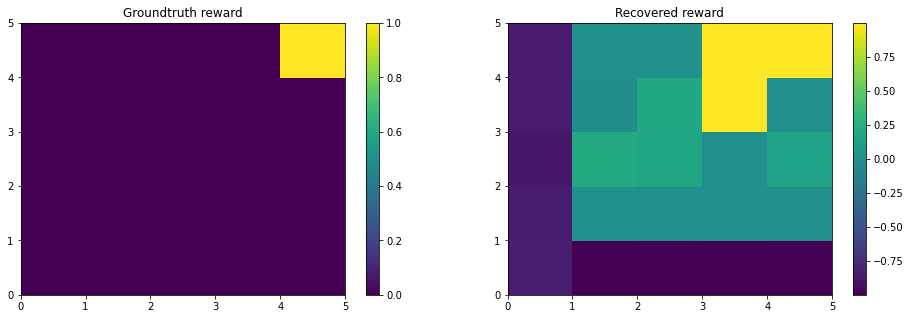

In [9]:
r = main(5, 0.5)

In [46]:
r.reshape(5,5)

array([[-2.26549300e-09, -1.59804034e-06, -1.31850600e-10,
        -1.51879878e-07, -1.48441546e-07],
       [ 6.95960136e-04,  4.11082582e-03, -3.52689099e-09,
        -7.94960710e-10, -9.18166253e-10],
       [-1.02548836e-05,  4.35343747e-03,  2.56610326e-02,
        -1.95641595e-09, -6.61843823e-10],
       [-1.09650591e-05, -2.65271372e-09,  2.70904208e-02,
         1.60190629e-01, -1.10974051e-09],
       [-1.25445045e-09,  3.15285900e-09,  1.03220907e-09,
         1.42886026e-01,  1.00000000e+00]])